# atma cup 10th

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import KFold, StratifiedKFold

from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)

import pycld2 as cld2
from gensim.models import word2vec, KeyedVectors
from PIL import ImageColor

import torch
import transformers
from geopy.geocoders import Nominatim
import os
from glob import glob

In [293]:
input_dir = "../input/"
output_dir = "../output/"

lgm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 42,
    'max_depth': 8,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.03,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 71,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

# Utils

In [294]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Read Data

In [295]:
train_df = pd.read_csv(input_dir + "train.csv")
test_df = pd.read_csv(input_dir + "test.csv")
submission = pd.read_csv(input_dir + "atmacup10__sample_submission.csv")
color_df = pd.read_csv(input_dir + "color.csv")
histrical_df = pd.read_csv(input_dir + "historical_person.csv")
maker_df = pd.read_csv(input_dir + "maker.csv")
collection_df = pd.read_csv(input_dir + "object_collection.csv")
material_df = pd.read_csv(input_dir + "material.csv")
palette_df = pd.read_csv(input_dir + "palette.csv")
production_place_df = pd.read_csv(input_dir + "production_place.csv")
occupation_df = pd.read_csv(input_dir + "principal_maker_occupation.csv")
principal_maker_df = pd.read_csv(input_dir + "principal_maker.csv")
production_place_df = pd.read_csv(input_dir + "production_place.csv")
technique_df = pd.read_csv(input_dir + "technique.csv")

In [296]:
train_df.shape

(12026, 19)

# Add data preprocess

In [297]:
def place2country(address):
    geolocator = Nominatim(user_agent='sample', timeout=200)
    loc = geolocator.geocode(address, language='en')
    coordinates = (loc.latitude, loc.longitude)
    location = geolocator.reverse(coordinates, language='en')
    country = location.raw['address']['country']
    return country

production_place_df2 = production_place_df.copy()

place_list = production_place_df2['name'].unique()
country_dict = {}
for place in tqdm(place_list):
    try:
        country = place2country(place)
        country_dict[place] = country
    except:
        # 国名を取得できない場合はnan
        print(place)
        country_dict[place] = np.nan

 81%|████████▏ | 117/144 [02:13<00:26,  1.03it/s]

Indonesian Archipelago


 97%|█████████▋| 139/144 [02:37<00:04,  1.02it/s]

Nisida, Isola di


100%|██████████| 144/144 [02:43<00:00,  1.14s/it]


In [298]:
production_place_df2['country_name'] = production_place_df2['name'].map(country_dict)

production_place_df2 = production_place_df2[["object_id", 'country_name']]

In [299]:
# cha_kabuさん参考
# https://www.guruguru.science/competitions/16/discussions/4e8bbf3e-af2c-47bb-9620-51e3b00336b6/

def get_wide_df(input_df):
    # DataFrameの変数名を取得する関数
    def get_df_name(_df):
        name =[x for x in globals() if globals()[x] is _df][0]
        return name

    _df = input_df.copy()
    max_size = _df.groupby('object_id').size().max()
    _df['cumcount'] = _df.groupby('object_id').cumcount()
    output_df = pd.DataFrame({'object_id': _df['object_id'].unique()})
    _df_name = get_df_name(input_df)

    for i in range(max_size):
        temp_df = _df[_df['cumcount']==i].reset_index(drop=True)
        output_df = output_df.merge(temp_df[['object_id', 'name']], on='object_id', how='left').rename(columns={'name':f'{_df_name}_{i}'})

    return output_df

# production_place_df
production_place_df = get_wide_df(production_place_df)
production_place_df = production_place_df[["object_id", "production_place_df_0", "production_place_df_1"]]

# histrical_df
histrical_df = get_wide_df(histrical_df)
histrical_df = histrical_df[["object_id", "histrical_df_0", "histrical_df_1"]]



train_df = pd.merge(train_df, production_place_df, on="object_id", how="left")
test_df = pd.merge(test_df, production_place_df, on="object_id", how="left")

train_df = pd.merge(train_df, histrical_df, on="object_id", how="left")
test_df = pd.merge(test_df, histrical_df, on="object_id", how="left")



In [300]:
occupation_df["id"] = occupation_df["id"].astype(str)

def get_wide_df_for_occupation(input_df):
    # DataFrameの変数名を取得する関数
    def get_df_name(_df):
        name =[x for x in globals() if globals()[x] is _df][0]
        return name

    _df = input_df.copy()
    max_size = _df.groupby('id').size().max()
    _df['cumcount'] = _df.groupby('id').cumcount()
    output_df = pd.DataFrame({'id': _df['id'].unique()})
    _df_name = get_df_name(input_df)

    for i in range(max_size):
        temp_df = _df[_df['cumcount']==i].reset_index(drop=True)
        output_df = output_df.merge(temp_df[['id', 'name']], on='id', how='left').rename(columns={'name':f'{_df_name}_{i}'})

    return output_df

# occupation_df
occupation_df = get_wide_df_for_occupation(occupation_df)
occupation_df = occupation_df[["id", "occupation_df_0", "occupation_df_1"]]

In [301]:
principal_maker_df.shape

(24538, 6)

In [302]:
principal_maker_df["id"] = principal_maker_df["id"].astype(str)
principal_maker_df = pd.merge(principal_maker_df, occupation_df, on="id", how="left")

In [303]:
principal_maker_qualification = principal_maker_df[["object_id", "qualification"]]
principal_maker_roles = principal_maker_df[["object_id", "roles"]]

def get_wide_df_for_qualification(input_df):
    # DataFrameの変数名を取得する関数
    def get_df_name(_df):
        name =[x for x in globals() if globals()[x] is _df][0]
        return name

    _df = input_df.copy()
    max_size = _df.groupby('object_id').size().max()
    _df['cumcount'] = _df.groupby('object_id').cumcount()
    output_df = pd.DataFrame({'object_id': _df['object_id'].unique()})
    _df_name = get_df_name(input_df)

    for i in range(max_size):
        temp_df = _df[_df['cumcount']==i].reset_index(drop=True)
        output_df = output_df.merge(temp_df[['object_id', 'qualification']], on='object_id', how='left').rename(columns={'qualification':f'{_df_name}_{i}'})

    return output_df

def get_wide_df_for_roles(input_df):
    # DataFrameの変数名を取得する関数
    def get_df_name(_df):
        name =[x for x in globals() if globals()[x] is _df][0]
        return name

    _df = input_df.copy()
    max_size = _df.groupby('object_id').size().max()
    _df['cumcount'] = _df.groupby('object_id').cumcount()
    output_df = pd.DataFrame({'object_id': _df['object_id'].unique()})
    _df_name = get_df_name(input_df)

    for i in range(max_size):
        temp_df = _df[_df['cumcount']==i].reset_index(drop=True)
        output_df = output_df.merge(temp_df[['object_id', 'roles']], on='object_id', how='left').rename(columns={'roles':f'{_df_name}_{i}'})

    return output_df

def get_wide_df_for_country(input_df):
    # DataFrameの変数名を取得する関数
    def get_df_name(_df):
        name =[x for x in globals() if globals()[x] is _df][0]
        return name

    _df = input_df.copy()
    max_size = _df.groupby('object_id').size().max()
    _df['cumcount'] = _df.groupby('object_id').cumcount()
    output_df = pd.DataFrame({'object_id': _df['object_id'].unique()})
    _df_name = get_df_name(input_df)

    for i in range(max_size):
        temp_df = _df[_df['cumcount']==i].reset_index(drop=True)
        output_df = output_df.merge(temp_df[['object_id', 'country_name']], on='object_id', how='left').rename(columns={'country_name':f'{_df_name}_{i}'})

    return output_df

# principal_maker_qualification
principal_maker_qualification = get_wide_df_for_qualification(principal_maker_qualification)
principal_maker_qualification = principal_maker_qualification[["object_id", "principal_maker_qualification_0", "principal_maker_qualification_1"]]

# principal_maker_roles
principal_maker_roles = get_wide_df_for_roles(principal_maker_roles)
principal_maker_roles = principal_maker_roles[["object_id", "principal_maker_roles_0", "principal_maker_roles_1"]]

# country_name
production_place_df2 = get_wide_df_for_country(production_place_df2)
production_place_df2 = production_place_df2[["object_id", "production_place_df2_0"]]

In [304]:
train_df = pd.merge(train_df, principal_maker_qualification, on="object_id", how="left")
train_df = pd.merge(train_df, principal_maker_roles, on="object_id", how="left")
train_df = pd.merge(train_df, production_place_df2, on="object_id", how="left")


test_df = pd.merge(test_df, principal_maker_qualification, on="object_id", how="left")
test_df = pd.merge(test_df, principal_maker_roles, on="object_id", how="left")
test_df = pd.merge(test_df, production_place_df2, on="object_id", how="left")

In [305]:
# Word2Vecを使ってmaterial, technique, object_collectionなどを特徴ベクトル化 araiさん
mat_col = pd.concat([material_df, collection_df], axis=0).reset_index(drop=True)
mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
col_tec = pd.concat([collection_df, technique_df], axis=0).reset_index(drop=True)
mat_col_tec = pd.concat([material_df, collection_df, technique_df], axis=0).reset_index(drop=True)

model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}

n_iter = 100

w2v_dfs = []
for df, df_name in zip(
        [
            material_df, collection_df, technique_df,
            mat_col, mat_tec, col_tec, mat_col_tec
        ], [
            "material", "collection", "technique",
            "material_collection",
            "material_technique",
            "collection_technique",
            "material_collection_technique"
        ]):
    df_group = df.groupby("object_id")["name"].apply(list).reset_index()
    # Word2Vecの学習
    w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                  size=model_size[df_name],
                                  min_count=1,
                                  window=1,
                                  iter=n_iter)

    # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
    sentence_vectors = df_group["name"].apply(
        lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
    sentence_vectors = np.vstack([x for x in sentence_vectors])
    sentence_vector_df = pd.DataFrame(sentence_vectors,
                                      columns=[f"{df_name}_w2v_{i}"
                                               for i in range(model_size[df_name])])
    sentence_vector_df.index = df_group["object_id"]
    w2v_dfs.append(sentence_vector_df)

In [306]:
"""
train_df = pd.merge(train_df, material_df, on="object_id", how="left")
test_df = pd.merge(test_df, material_df, on="object_id", how="left")

train_df = pd.merge(train_df, technique_df, on="object_id", how="left")
test_df = pd.merge(test_df, technique_df, on="object_id", how="left")

train_df = pd.merge(train_df, collection_df, on="object_id", how="left")
test_df = pd.merge(test_df, collection_df, on="object_id", how="left")
"""
for i in range(3):
    train_df = pd.merge(train_df, w2v_dfs[i], on="object_id", how="left")
    test_df = pd.merge(test_df, w2v_dfs[i], on="object_id", how="left")


In [307]:
# color.csvの変換
_color_df = pd.DataFrame(color_df['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), columns=['R', 'G', 'B'])
color_df = color_df[["object_id", "percentage"]]
color_df["percentage"] = color_df["percentage"]/100

color_df = pd.concat([color_df, _color_df], axis=1)

In [308]:
train_df.shape

(12026, 59)

In [309]:
# principal_maker merge
#train_df = pd.merge(train_df, principal_maker_df, on="object_id", how="left")

In [310]:
train_df.shape

(12026, 59)

# Preprocess

In [311]:
# 最終的な処理にかける前に先に行う処理（本当は中に入れ子にしたい）
# Arai-san参考
def search_title_lang(input_df):        
    input_df["title_lang"] = input_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    
    return input_df["title_lang"]


combine = [train_df, test_df]
for dataset in combine:
    dataset = search_title_lang(dataset)
    

In [312]:
from transformers import BertTokenizer

BERT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "bert-base-uncased",
    "bert-large-uncased",
    "bert-base-cased",
    "bert-large-cased",
    "bert-base-multilingual-uncased",
    "bert-base-multilingual-cased",
    "bert-base-chinese",
    "bert-base-german-cased",
    "bert-large-uncased-whole-word-masking",
    "bert-large-cased-whole-word-masking",
    "bert-large-uncased-whole-word-masking-finetuned-squad",
    "bert-large-cased-whole-word-masking-finetuned-squad",
    "bert-base-cased-finetuned-mrpc",
    "bert-base-german-dbmdz-cased",
    "bert-base-german-dbmdz-uncased",
    "cl-tohoku/bert-base-japanese",
    "cl-tohoku/bert-base-japanese-whole-word-masking",
    "cl-tohoku/bert-base-japanese-char",
    "cl-tohoku/bert-base-japanese-char-whole-word-masking",
    "TurkuNLP/bert-base-finnish-cased-v1",
    "TurkuNLP/bert-base-finnish-uncased-v1",
    "wietsedv/bert-base-dutch-cased",
    # See all BERT models at https://huggingface.co/models?filter=bert
]

class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [313]:
BSV = BertSequenceVectorizer()

title_train_df = train_df[['object_id', 'description']]
title_test_df = test_df[['object_id', 'description']]

title_train_df['description'] = title_train_df['description'].fillna("NaN") 
title_test_df['description'] = title_test_df['description'].fillna("NaN") 

title_train_df['description_feature'] = title_train_df['description'].apply(lambda x: BSV.vectorize(x))
title_test_df['description_feature'] = title_test_df['description'].apply(lambda x: BSV.vectorize(x))

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site

In [314]:
from sklearn.decomposition import PCA

def create_input_array_pca(input_df):
    features = []
    for array in input_df['description_feature']:
        features.append(array)
    return pd.DataFrame(features).values.astype(np.float32)

def result_description_pca(input_df,N):
    pca = PCA(n_components=N).fit(input_df)
    transformed = pca.transform(input_df)
    for n in range(N):
        print(f'第 {n+1} 主成分：{pca.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed)

_title_train_df = create_input_array_pca(title_train_df)
_title_test_df = create_input_array_pca(title_test_df)

_title_train_df = result_description_pca(_title_train_df, 3)
_title_test_df = result_description_pca(_title_test_df, 3)

第 1 主成分：0.5645526051521301
第 2 主成分：0.17398206889629364
第 3 主成分：0.047664251178503036
第 1 主成分：0.576203465461731
第 2 主成分：0.16705383360385895
第 3 主成分：0.04664217308163643


In [315]:
_title_train_df = _title_train_df.rename(columns={0:"description_0", 1:"description_1", 2:"description_2"})
_title_test_df = _title_test_df.rename(columns={0:"description_0", 1:"description_1", 2:"description_2"})

train_df = pd.concat([train_df, _title_train_df], axis=1)
test_df = pd.concat([test_df, _title_test_df], axis=1)

In [316]:
train_df.shape

(12026, 63)

In [317]:
# baseBlock 

class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")
    
# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [318]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = [
        "copyright_holder",
        "acquisition_method",
        "principal_maker",
        "principal_or_first_maker",
        "title_lang",
        "production_place_df_0",
        "production_place_df_1",
        "histrical_df_0",
        "histrical_df_1",
        "principal_maker_qualification_0",
        "principal_maker_qualification_1",
        "principal_maker_roles_0",
        "principal_maker_roles_1",
        "production_place_df2_0"
    ]
    
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        "copyright_holder",
        "acquisition_method",
        "principal_maker",
        "principal_or_first_maker",
        "production_place_df_0",
        "production_place_df_1",
        "histrical_df_0",
        "histrical_df_1",
        "principal_maker_qualification_0",
        "principal_maker_qualification_1",
        "principal_maker_roles_0",
        "principal_maker_roles_1",
        "production_place_df2_0",
        "title_lang"
       
    ]
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = [
        #"copyright_holder",
        #"acquisition_method",
        #"principal_maker",
        "title_lang",
        "production_place_df_0",
        "production_place_df_1",
        #"material_df_0",
        #"collection_df_0",
        #"technique_df_0",
    ]
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

# titlelength
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

# numeric_feature
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'material_w2v_0', 'material_w2v_1',
        'material_w2v_2', 'material_w2v_3', 'material_w2v_4', 'material_w2v_5',
        'material_w2v_6', 'material_w2v_7', 'material_w2v_8', 'material_w2v_9',
        'material_w2v_10', 'material_w2v_11', 'material_w2v_12',
        'material_w2v_13', 'material_w2v_14', 'material_w2v_15',
        'material_w2v_16', 'material_w2v_17', 'material_w2v_18',
        'material_w2v_19', 'collection_w2v_0', 'collection_w2v_1',
        'collection_w2v_2', 'technique_w2v_0', 'technique_w2v_1',
        'technique_w2v_2', 'technique_w2v_3', 'technique_w2v_4',
        'technique_w2v_5', 'technique_w2v_6', 'technique_w2v_7',
        "description_0","description_1","description_2"
    ]

    return input_df[use_columns].copy()

# palette特徴量の追加(discussionから変更)
def create_palette_feature(input_df):
    output_df = input_df.copy()
    palette = palette_df.copy()

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_palette, on="object_id", how="left")
    
    # ratio最小のものを取得
    min_palette = palette.groupby('object_id')['ratio'].min().reset_index()
    min_palette = pd.merge(min_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"min_ratio", "color_r":"min_palette_r", "color_g":"min_palette_g","color_b":"min_palette_b"})  
    min_palette = min_palette.loc[min_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmin ratioが同じものは削除
    output_df = pd.merge(output_df, min_palette, on="object_id", how="left")
    
    # 追加でvar
    var_palette = palette.groupby("object_id")["ratio"].var().reset_index()
    var_palette = pd.merge(var_palette, palette, on = ["object_id", "ratio"], how="left").rename(
    columns={"ratio":"var_ratio", "color_r":"var_palette_r", "color_g":"var_palette_g", "color_b":"var_palette_b"})
    var_palette = var_palette.loc[var_palette["object_id"].drop_duplicates().index.tolist()].reset_index()
    output_df = pd.merge(output_df, var_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")

    use_columns = ["max_ratio", "max_palette_r","max_palette_g","max_palette_b",
                   "min_ratio", "min_palette_r","min_palette_g","min_palette_b",
                   "mean_palette_r","mean_palette_g","mean_palette_b", "var_ratio"]
    return output_df[use_columns]

# color特徴量の追加(discussionから変更)
def create_color_feature(input_df):
    output_df = input_df.copy()
    color = color_df.copy()

    # ratio最大のものを取得
    max_color = color.groupby('object_id')['percentage'].max().reset_index()
    max_color = pd.merge(max_color, color, on=['object_id','percentage'], how='left').rename(
        columns={"percentage":"max_percentage", "R":"max_color_r", "G":"max_color_g","B":"max_color_b"})  
    max_color = max_color.loc[max_color["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_color, on="object_id", how="left")
    
    # ratio最小のものを取得
    min_color = color.groupby('object_id')['percentage'].min().reset_index()
    min_color = pd.merge(min_color, color, on=['object_id','percentage'], how='left').rename(
        columns={"percentage":"min_percentage", "R":"min_color_r", "G":"min_color_g","B":"min_color_b"})  
    min_color = min_color.loc[min_color["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmin ratioが同じものは削除
    output_df = pd.merge(output_df, min_color, on="object_id", how="left")
    
    # 追加でvar
    var_color = color.groupby("object_id")["percentage"].var().reset_index()
    var_color = pd.merge(var_color, color, on = ["object_id", "percentage"], how="left").rename(
    columns={"percentage":"var_percentage", "R":"var_color_r", "G":"var_color_g", "B":"var_color_b"})
    var_color = var_color.loc[var_color["object_id"].drop_duplicates().index.tolist()].reset_index()
    output_df = pd.merge(output_df, var_color, on="object_id", how="left")

    # 平均のrgbを取得
    mean_color = color.copy()
    mean_color["R"] = color["percentage"] * color["R"]
    mean_color["G"] = color["percentage"] * color["G"]
    mean_color["B"] = color["percentage"] * color["B"]
    mean_color = mean_color.groupby("object_id").sum().reset_index().rename(
        columns={"R":"mean_color_r", "G":"mean_color_g","B":"mean_color_b"})
    output_df = pd.merge(output_df, mean_color, on="object_id", how="left")

    use_columns = ["max_percentage", "max_color_r","max_color_g","max_color_b","mean_color_r",
                   "min_percentage", "min_color_r","min_color_g","min_color_b",
                   "mean_color_g","mean_color_b", "var_percentage"]
    return output_df[use_columns]

# aggration
def get_agg_principal_maker(input_df):
    cols = 'principal_maker'
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                      group_key=cols,
                                      group_values=['dating_period', 'dating_year_early','dating_year_late',
                                                   "description_0", "description_1", "description_2"],
                                                agg_methods=['count', 'mean', 'min', 'max',"var","std"],
                                               )
    return output_df[agg_cols]

# aggration length 
def get_agg_length(input_df):
    cols = 'principal_maker'
    
    _input_df = input_df.copy()
    _input_df2 = create_string_length_feature(_input_df)
    _input_df = pd.concat([_input_df,_input_df2],axis=1)
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                      group_key=cols,
                                      group_values=['StringLength__more_title', 'StringLength__title','StringLength__long_title',
                                                   "StringLength__sub_title", "StringLength__description"],
                                                agg_methods=['count', 'mean', 'min', 'max', "var", "std"],
                                               )
    
    return output_df[agg_cols]

# aggration palette
def get_agg_palette(input_df):
    cols = 'principal_maker'
    
    _input_df = input_df.copy()
    _input_df2 = create_palette_feature(_input_df)
    _input_df = pd.concat([_input_df,_input_df2],axis=1)
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(_input_df,
                                      group_key=cols,
                                      group_values=["max_ratio", "max_palette_r","max_palette_g","max_palette_b",
                                                    "min_ratio", "min_palette_r","min_palette_g","min_palette_b",
                                                    "mean_palette_r","mean_palette_g","mean_palette_b", "var_ratio"],
                                                agg_methods=['count', 'mean', 'min', 'max', "var"],
                                               )
    
    return output_df[agg_cols]

# aggration acquisition_method
def get_agg_acquisition_method(input_df):
    cols = 'acquisition_method'
    
    
    output_df = pd.DataFrame()
    output_df, agg_cols = aggregation(input_df,
                                      group_key=cols,
                                      group_values=['dating_period', 'dating_year_early','dating_year_late',
                                                   "description_0", "description_1", "description_2"],
                                                agg_methods=['count', 'mean', 'min', 'max', "var"],
                                               )
    
    return output_df[agg_cols]

# size infomation
def get_size_info(input_df):
    output_df = input_df.copy()
    
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = output_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        output_df[column_name] = size_info[column_name]
        
    use_columns = ['size_h', 'size_w', 'size_t', 'size_d']
    return output_df[use_columns]
        

In [319]:
# 前処理関数を順々に処理していく関数
def to_features(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_oe_features,
        get_ce_features,
        get_ohe_features,
        create_string_length_feature,
        create_numeric_feature,
        create_palette_feature,
        get_agg_principal_maker,
        create_color_feature,
        get_agg_length,
        get_size_info,
        #get_agg_palette,
        #get_agg_acquisition_method
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [320]:
target_data = "likes" 

train_x, test_x = to_features(train_df, test_df)
train_ys_for_split = train_df[target_data]
train_ys = train_df[target_data].values

train_ys = np.log1p(train_ys)
train_ys_for_split = np.log1p(train_ys_for_split)

 20%|██        | 2/10 [00:00<00:03,  2.61it/s]/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


In [321]:
train_x

,OE_copyright_holder,OE_acquisition_method,OE_principal_maker,OE_principal_or_first_maker,OE_production_place_df_0,OE_production_place_df_1,OE_histrical_df_0,OE_histrical_df_1,OE_principal_maker_qualification_0,OE_principal_maker_qualification_1,...,agg_var_StringLength__description_grpby_principal_maker,agg_std_StringLength__more_title_grpby_principal_maker,agg_std_StringLength__title_grpby_principal_maker,agg_std_StringLength__long_title_grpby_principal_maker,agg_std_StringLength__sub_title_grpby_principal_maker,agg_std_StringLength__description_grpby_principal_maker,size_h,size_w,size_t,size_d
0,1,1,1,1,1,1,1,1,1,1,...,2933.333333,4.207137,4.207137,5.338539,8.294577,54.160256,665.0,537.0,25.0,47.0
1,2,1,2,2,2,1,1,1,2,1,...,196.000000,41.177503,18.008751,18.591800,0.276968,14.000000,165.0,223.0,NaN,NaN
2,1,2,3,3,3,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,87.0,56.0,NaN,NaN
3,1,3,4,4,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1790.0,2480.0,40.0,NaN
4,1,4,5,5,4,1,1,1,1,1,...,26329.364453,82.183803,26.651931,27.565759,3.750976,162.263257,130.0,175.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,1,5,2220,2249,10,1,1204,1,1,1,...,NaN,8.326664,2.645751,5.000000,5.196152,NaN,90.0,140.0,NaN,NaN
12022,1,1,212,217,31,3,1,1,1,1,...,2071.050523,40.635343,11.041075,11.041075,0.000000,45.508796,245.0,278.0,NaN,NaN
12023,1,5,1041,1053,3,1,1,1,4,1,...,5744.500000,55.966955,17.753873,14.842507,0.000000,75.792480,217.0,306.0,NaN,NaN
12024,1,1,115,116,4,2,872,26,12,1,...,26956.910767,111.751531,22.433651,23.389273,0.881647,164.185599,560.0,405.0,NaN,NaN


In [322]:
# target encoding
fold = KFold(n_splits=5, shuffle=True, random_state=42)

encoder = TargetEncoder(
    input_cols=["copyright_holder",
        "acquisition_method",
        "principal_maker",
        "principal_or_first_maker",
        "histrical_df_0"], 
    target_col="likes",
    fold=fold,
    output_suffix="_re"
    )

te_cols = ["copyright_holder_re",
        "acquisition_method_re",
        "principal_maker_re", 
        "principal_or_first_maker_re",
        "histrical_df_0_re"
          ]

encoded_train = encoder.fit_transform(train_df)
encode_test = encoder.transform(test_df)

encoded_train = encoded_train[te_cols]
encoded_test = encode_test[te_cols]

In [323]:
train_x = pd.concat([train_x, encoded_train], axis=1)
test_x = pd.concat([test_x, encoded_test], axis=1)

# models

In [324]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i)**.5 :.4f}')

    score = metric_func(y, oof_pred)**.5 
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

# 回帰分析用のstratified
def create_stratified_folds_for_regression(data_df, n_splits=5):
    """
    @param data_df: training data to split in Stratified K Folds for a continous target value
    @param n_splits: number of splits
    @return: the training data with a column with kfold id
    """
    data_df['kfold'] = -1
    # randomize the data
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    # calculate the optimal number of bins based on log2(data_df.shape[0])
    num_bins = np.int(np.floor(1 + np.log2(len(data_df))))
    print(f"Num bins: {num_bins}")
    # bins value will be the equivalent of class value of target feature used by StratifiedKFold to 
    # distribute evenly the classed over each fold
    data_df.loc[:, "bins"] = pd.cut(pd.to_numeric(data_df['likes'], downcast="signed"), bins=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_splits)
    
    # set the fold id as a new column in the train data
    for f, (t_, v_) in enumerate(kf.split(X=data_df, y=data_df.bins.values)):
        data_df.loc[v_, 'kfold'] = f
    
    # drop the bins column (no longer needed)
    data_df = data_df.drop("bins", axis=1)
    
    return data_df

# stratified用のsplit
def kfold_splits(n_splits, train_df):
    """
    Returns a collection of (fold, train indexes, validation indexes)
    @param n_splits: number of splits
    @param train_df: training data
    @return: a collection of (fold, train indexes, validation indexes)
    """
    
    # not append "fold" => my function
    all_folds = list(range(0, n_splits))
    kf_splits = []
    for fold in range(0, n_splits):
        train_folds = [x for x in all_folds if x != fold]
        trn_idx = train_df[train_df.kfold!=fold].index
        val_idx = train_df[train_df.kfold==fold].index
        kf_splits.append((trn_idx, val_idx))
    return kf_splits


train_df_re = pd.concat([train_x, train_ys_for_split], axis=1)

In [325]:
n_splits = 5
train_df_re = create_stratified_folds_for_regression(train_df_re, n_splits)
stratified_cv = kfold_splits(n_splits, train_df_re)

Num bins: 14


In [326]:
fold = KFold(n_splits=10, shuffle=True, random_state=42)
cv = list(fold.split(train_x, train_ys)) # もともとが generator なため明示的に list に変換する

oof, models = fit_lgbm(train_x.values, train_ys, cv, params=lgm_params)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.11924
[100]	valid_0's rmse: 1.05845
[150]	valid_0's rmse: 1.04979
[200]	valid_0's rmse: 1.04454
[250]	valid_0's rmse: 1.04237
[300]	valid_0's rmse: 1.0402
[350]	valid_0's rmse: 1.03817
[400]	valid_0's rmse: 1.03732
[450]	valid_0's rmse: 1.03593
[500]	valid_0's rmse: 1.03378
[550]	valid_0's rmse: 1.03237
[600]	valid_0's rmse: 1.0312
[650]	valid_0's rmse: 1.02939
[700]	valid_0's rmse: 1.02952
Early stopping, best iteration is:
[649]	valid_0's rmse: 1.02929
fit fold=1 5.407[s]
Fold 0 RMSLE: 1.0293
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.08057
[100]	valid_0's rmse: 1.00733
[150]	valid_0's rmse: 0.993695
[200]	valid_0's rmse: 0.988379
[250]	valid_0's rmse: 0.987443
[300]	valid_0's rmse: 0.98619
[350]	valid_0's rmse: 0.984437
[400]	valid_0's rmse: 0.981121
[450]	valid_0's rmse: 0.979234
[500]	valid_0's rmse: 0.978125
[550]	valid_0's rmse: 0.97762
[600]	valid_0's rmse: 0.978452
[650]	valid_0's rmse: 0.979239
Early stopping, best iteration is:
[582]	valid_0's rmse: 0.977257
fit fold=2 5.220[s]
Fold 1 RMSLE: 0.9773
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.16904
[100]	valid_0's rmse: 1.0963
[150]	valid_0's rmse: 1.08147
[200]	valid_0's rmse: 1.07373
[250]	valid_0's rmse: 1.06887
[300]	valid_0's rmse: 1.06599
[350]	valid_0's rmse: 1.06437
[400]	valid_0's rmse: 1.06224
[450]	valid_0's rmse: 1.06092
[500]	valid_0's rmse: 1.05925
[550]	valid_0's rmse: 1.0578
[600]	valid_0's rmse: 1.05765
[650]	valid_0's rmse: 1.05728
[700]	valid_0's rmse: 1.05669
[750]	valid_0's rmse: 1.05624
[800]	valid_0's rmse: 1.05512
[850]	valid_0's rmse: 1.05521
Early stopping, best iteration is:
[784]	valid_0's rmse: 1.05475
fit fold=3 7.545[s]
Fold 2 RMSLE: 1.0548
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.09817
[100]	valid_0's rmse: 1.03176
[150]	valid_0's rmse: 1.01997
[200]	valid_0's rmse: 1.01543
[250]	valid_0's rmse: 1.0129
[300]	valid_0's rmse: 1.01107
[350]	valid_0's rmse: 1.00944
[400]	valid_0's rmse: 1.00849
[450]	valid_0's rmse: 1.00837
[500]	valid_0's rmse: 1.0079
[550]	valid_0's rmse: 1.0075
[600]	valid_0's rmse: 1.00649
[650]	valid_0's rmse: 1.00668
[700]	valid_0's rmse: 1.00597
[750]	valid_0's rmse: 1.00617
[800]	valid_0's rmse: 1.00653
Early stopping, best iteration is:
[706]	valid_0's rmse: 1.00582
fit fold=4 6.731[s]
Fold 3 RMSLE: 1.0058
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM]

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.12714
[100]	valid_0's rmse: 1.05092
[150]	valid_0's rmse: 1.0366
[200]	valid_0's rmse: 1.03191
[250]	valid_0's rmse: 1.02734
[300]	valid_0's rmse: 1.0261
[350]	valid_0's rmse: 1.02425
[400]	valid_0's rmse: 1.02221
[450]	valid_0's rmse: 1.02088
[500]	valid_0's rmse: 1.01958
[550]	valid_0's rmse: 1.0182
[600]	valid_0's rmse: 1.01783
[650]	valid_0's rmse: 1.01759
Early stopping, best iteration is:
[574]	valid_0's rmse: 1.01694
fit fold=5 4.999[s]
Fold 4 RMSLE: 1.0169
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Cur

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.1513
[100]	valid_0's rmse: 1.08555
[150]	valid_0's rmse: 1.07263
[200]	valid_0's rmse: 1.06889
[250]	valid_0's rmse: 1.065
[300]	valid_0's rmse: 1.06313
[350]	valid_0's rmse: 1.06057
[400]	valid_0's rmse: 1.058
[450]	valid_0's rmse: 1.05717
[500]	valid_0's rmse: 1.05469
[550]	valid_0's rmse: 1.05457
[600]	valid_0's rmse: 1.05314
[650]	valid_0's rmse: 1.05145
[700]	valid_0's rmse: 1.05061
[750]	valid_0's rmse: 1.05068
[800]	valid_0's rmse: 1.05059
[850]	valid_0's rmse: 1.05065
[900]	valid_0's rmse: 1.0511
Early stopping, best iteration is:
[819]	valid_0's rmse: 1.05022
fit fold=6 6.494[s]
Fold 5 RMSLE: 1.0502


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
Training until validation scores don't improve for 100 rounds


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
Training until validation scores don't improve for 100 rounds


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.09771
[100]	valid_0's rmse: 1.00909
[150]	valid_0's rmse: 0.990457
[200]	valid_0's rmse: 0.983095
[250]	valid_0's rmse: 0.979772
[300]	valid_0's rmse: 0.977822
[350]	valid_0's rmse: 0.975518
[400]	valid_0's rmse: 0.97393
[450]	valid_0's rmse: 0.973101
[500]	valid_0's rmse: 0.971614
[550]	valid_0's rmse: 0.970736
[600]	valid_0's rmse: 0.970161
[650]	valid_0's rmse: 0.969926
[700]	valid_0's rmse: 0.971385
Early stopping, best iteration is:
[643]	valid_0's rmse: 0.969718
fit fold=9 5.578[s]
Fold 8 RMSLE: 0.9697
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, e

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.13588
[100]	valid_0's rmse: 1.08006
[150]	valid_0's rmse: 1.07039
[200]	valid_0's rmse: 1.06653
[250]	valid_0's rmse: 1.06438
[300]	valid_0's rmse: 1.06274
[350]	valid_0's rmse: 1.06039
[400]	valid_0's rmse: 1.06104
[450]	valid_0's rmse: 1.06066
[500]	valid_0's rmse: 1.05915
[550]	valid_0's rmse: 1.05782
[600]	valid_0's rmse: 1.05825
Early stopping, best iteration is:
[549]	valid_0's rmse: 1.05767
fit fold=10 4.201[s]
Fold 9 RMSLE: 1.0577
FINISHED | Whole RMSLE: 1.0212


In [327]:
fold2 = KFold(n_splits=5, shuffle=True, random_state=23)
cv2 = list(fold.split(train_x, train_ys)) # もともとが generator なため明示的に list に変換する

oof2, models2 = fit_lgbm(train_x.values, train_ys, cv2, params=lgm_params)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.11924
[100]	valid_0's rmse: 1.05845
[150]	valid_0's rmse: 1.04979
[200]	valid_0's rmse: 1.04454
[250]	valid_0's rmse: 1.04237
[300]	valid_0's rmse: 1.0402
[350]	valid_0's rmse: 1.03817
[400]	valid_0's rmse: 1.03732
[450]	valid_0's rmse: 1.03593
[500]	valid_0's rmse: 1.03378
[550]	valid_0's rmse: 1.03237
[600]	valid_0's rmse: 1.0312
[650]	valid_0's rmse: 1.02939
[700]	valid_0's rmse: 1.02952
Early stopping, best iteration is:
[649]	valid_0's rmse: 1.02929
fit fold=1 5.736[s]
Fold 0 RMSLE: 1.0293
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.08057
[100]	valid_0's rmse: 1.00733
[150]	valid_0's rmse: 0.993695
[200]	valid_0's rmse: 0.988379
[250]	valid_0's rmse: 0.987443
[300]	valid_0's rmse: 0.98619
[350]	valid_0's rmse: 0.984437
[400]	valid_0's rmse: 0.981121
[450]	valid_0's rmse: 0.979234
[500]	valid_0's rmse: 0.978125
[550]	valid_0's rmse: 0.97762
[600]	valid_0's rmse: 0.978452
[650]	valid_0's rmse: 0.979239
Early stopping, best iteration is:
[582]	valid_0's rmse: 0.977257
fit fold=2 4.825[s]
Fold 1 RMSLE: 0.9773
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.16904
[100]	valid_0's rmse: 1.0963
[150]	valid_0's rmse: 1.08147
[200]	valid_0's rmse: 1.07373
[250]	valid_0's rmse: 1.06887
[300]	valid_0's rmse: 1.06599
[350]	valid_0's rmse: 1.06437
[400]	valid_0's rmse: 1.06224
[450]	valid_0's rmse: 1.06092
[500]	valid_0's rmse: 1.05925
[550]	valid_0's rmse: 1.0578
[600]	valid_0's rmse: 1.05765
[650]	valid_0's rmse: 1.05728
[700]	valid_0's rmse: 1.05669
[750]	valid_0's rmse: 1.05624
[800]	valid_0's rmse: 1.05512
[850]	valid_0's rmse: 1.05521
Early stopping, best iteration is:
[784]	valid_0's rmse: 1.05475
fit fold=3 6.714[s]
Fold 2 RMSLE: 1.0548
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.09817
[100]	valid_0's rmse: 1.03176
[150]	valid_0's rmse: 1.01997
[200]	valid_0's rmse: 1.01543
[250]	valid_0's rmse: 1.0129
[300]	valid_0's rmse: 1.01107
[350]	valid_0's rmse: 1.00944
[400]	valid_0's rmse: 1.00849
[450]	valid_0's rmse: 1.00837
[500]	valid_0's rmse: 1.0079
[550]	valid_0's rmse: 1.0075
[600]	valid_0's rmse: 1.00649
[650]	valid_0's rmse: 1.00668
[700]	valid_0's rmse: 1.00597
[750]	valid_0's rmse: 1.00617
[800]	valid_0's rmse: 1.00653
Early stopping, best iteration is:
[706]	valid_0's rmse: 1.00582
fit fold=4 6.661[s]
Fold 3 RMSLE: 1.0058
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM]

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.12714
[100]	valid_0's rmse: 1.05092
[150]	valid_0's rmse: 1.0366
[200]	valid_0's rmse: 1.03191
[250]	valid_0's rmse: 1.02734
[300]	valid_0's rmse: 1.0261
[350]	valid_0's rmse: 1.02425
[400]	valid_0's rmse: 1.02221
[450]	valid_0's rmse: 1.02088
[500]	valid_0's rmse: 1.01958
[550]	valid_0's rmse: 1.0182
[600]	valid_0's rmse: 1.01783
[650]	valid_0's rmse: 1.01759
Early stopping, best iteration is:
[574]	valid_0's rmse: 1.01694
fit fold=5 5.778[s]
Fold 4 RMSLE: 1.0169
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Cur

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's rmse: 1.1513
[100]	valid_0's rmse: 1.08555
[150]	valid_0's rmse: 1.07263
[200]	valid_0's rmse: 1.06889
[250]	valid_0's rmse: 1.065
[300]	valid_0's rmse: 1.06313
[350]	valid_0's rmse: 1.06057
[400]	valid_0's rmse: 1.058
[450]	valid_0's rmse: 1.05717
[500]	valid_0's rmse: 1.05469
[550]	valid_0's rmse: 1.05457
[600]	valid_0's rmse: 1.05314
[650]	valid_0's rmse: 1.05145
[700]	valid_0's rmse: 1.05061
[750]	valid_0's rmse: 1.05068
[800]	valid_0's rmse: 1.05059
[850]	valid_0's rmse: 1.05065
[900]	valid_0's rmse: 1.0511
Early stopping, best iteration is:
[819]	valid_0's rmse: 1.05022
fit fold=6 6.357[s]
Fold 5 RMSLE: 1.0502


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
Training until validation scores don't improve for 100 rounds


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.14561
[100]	valid_0's rmse: 1.07591
[150]	valid_0's rmse: 1.06149
[200]	valid_0's rmse: 1.0566
[250]	valid_0's rmse: 1.05242
[300]	valid_0's rmse: 1.04951
[350]	valid_0's rmse: 1.04758
[400]	valid_0's rmse: 1.04578
[450]	valid_0's rmse: 1.04379
[500]	valid_0's rmse: 1.04364
[550]	valid_0's rmse: 1.0431
[600]	valid_0's rmse: 1.043
[650]	valid_0's rmse: 1.04211
[700]	valid_0's rmse: 1.04143
[750]	valid_0's rmse: 1.0401
[800]	valid_0's rmse: 1.03908
[850]	valid_0's rmse: 1.03824
[900]	valid_0's rmse: 1.03737
[950]	valid_0's rmse: 1.03767
Early stopping, best iteration is:
[887]	valid_0's rmse: 1.03718
fit fold=8 6.459[s]
Fold 7 RMSLE: 1.0372
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lamb

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.09771
[100]	valid_0's rmse: 1.00909
[150]	valid_0's rmse: 0.990457
[200]	valid_0's rmse: 0.983095
[250]	valid_0's rmse: 0.979772
[300]	valid_0's rmse: 0.977822
[350]	valid_0's rmse: 0.975518
[400]	valid_0's rmse: 0.97393
[450]	valid_0's rmse: 0.973101
[500]	valid_0's rmse: 0.971614
[550]	valid_0's rmse: 0.970736
[600]	valid_0's rmse: 0.970161
[650]	valid_0's rmse: 0.969926
[700]	valid_0's rmse: 0.971385
Early stopping, best iteration is:
[643]	valid_0's rmse: 0.969718
fit fold=9 5.323[s]
Fold 8 RMSLE: 0.9697
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] early_stopping_round is set=100, e

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 1.13588
[100]	valid_0's rmse: 1.08006
[150]	valid_0's rmse: 1.07039
[200]	valid_0's rmse: 1.06653
[250]	valid_0's rmse: 1.06438
[300]	valid_0's rmse: 1.06274
[350]	valid_0's rmse: 1.06039
[400]	valid_0's rmse: 1.06104
[450]	valid_0's rmse: 1.06066
[500]	valid_0's rmse: 1.05915
[550]	valid_0's rmse: 1.05782
[600]	valid_0's rmse: 1.05825
Early stopping, best iteration is:
[549]	valid_0's rmse: 1.05767
fit fold=10 4.717[s]
Fold 9 RMSLE: 1.0577
FINISHED | Whole RMSLE: 1.0212


In [328]:
# XGB

def fit_xgb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_squared_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        model_xgb = xgb.XGBRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],verbose=-1)
            
        #print(model_xgb.best_score())
        
        pred_i = model_xgb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_xgb)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i)**.5 :.4f}')

    score = metric_func(y, oof_pred)**.5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

# Catboost
def fit_cb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_squared_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        train_pool = Pool(x_train, label = y_train)
        valid_pool = Pool(x_valid, label = y_valid)
        
        model_cb = CatBoostRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_cb.fit(train_pool,
              # valid_data
              eval_set = valid_pool,
              use_best_model = True,
              silent = True,
              plot = False)
            
        print(model_cb.get_best_score())
        
        pred_i = model_cb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_cb)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i)**.5 :.4f}')

    score = metric_func(y, oof_pred)**.5 
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

# Visualize_Importance

In [329]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

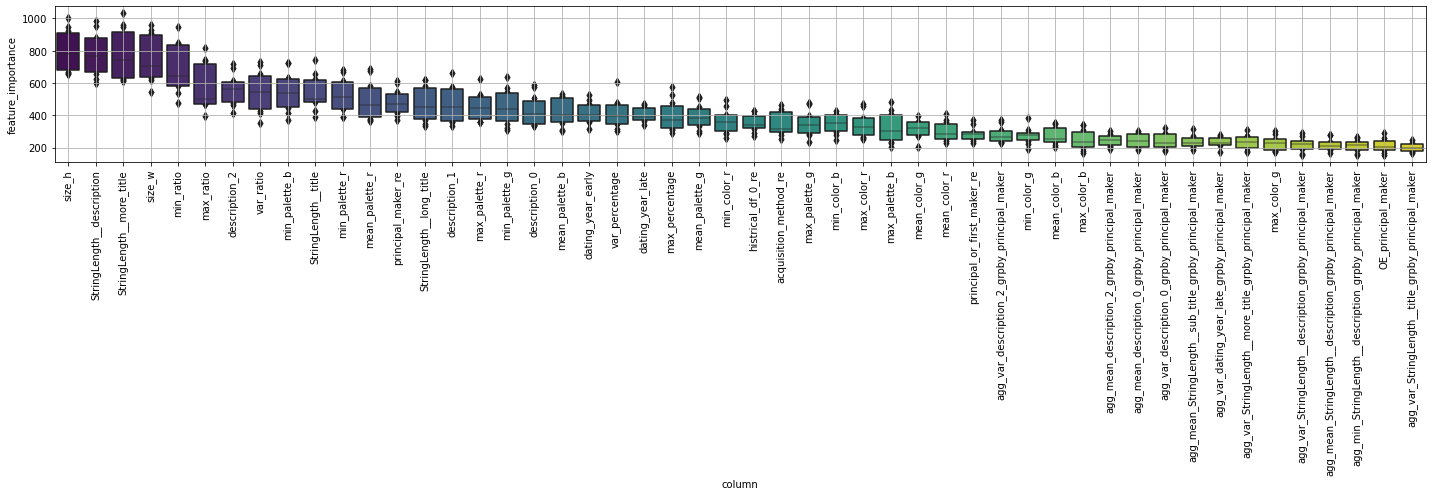

In [330]:
fig, ax = visualize_importance(models, train_x)

In [331]:
date="20210313_10"

pred1 = np.array([model.predict(test_x.values) for model in models])
pred1 = np.mean(pred1, axis=0)
pred1 = np.where(pred1 < 0, 0, pred1)
pred1 = np.expm1(pred1)

pred2 = np.array([model.predict(test_x.values) for model in models2])
pred2 = np.mean(pred2, axis=0)
pred2 = np.where(pred2 < 0, 0, pred2)
pred2 = np.expm1(pred2)

pred_em = (pred1+pred2)/2

submission["likes"] = pred_em
submission.to_csv(output_dir + "date" + date +'_simple_submission.csv', index=False)

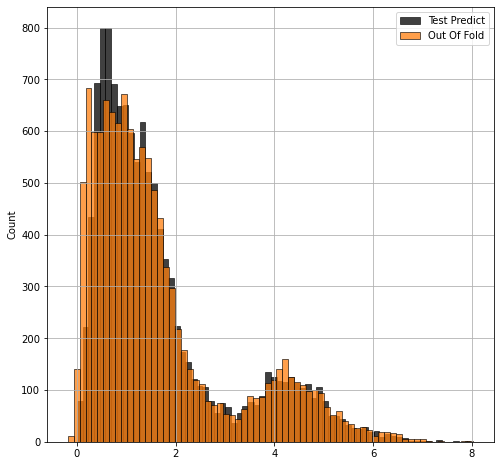

In [332]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred1), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()